# pyflwdir 測試

主要是看能不能使用上頭前溪的資料，看會不會用，能不能達到專案的需求

雖然還有問題，但似乎我們專案要用的東西，具備了

目前可以產生頭前溪的

1.線圖

2.子流域

3.算一點上游的集水區

4.算兩點之間的集水區

5.取得通過幾點下游的線圖



In [1]:
#畫圖要用的函示
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import cartopy.crs as ccrs
import descartes
import numpy as np
np.random.seed(seed=101)
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.dpi'] = 256
plt.style.use('seaborn-whitegrid')

def quickplot(gdfs=[], maps=[], hillshade=True, title='', filename='flw', save=False):
    fig = plt.figure(figsize=(8,15))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    # plot hillshade background
    if hillshade:
        ls = matplotlib.colors.LightSource(azdeg=115, altdeg=45)
        hillshade = ls.hillshade(np.ma.masked_equal(elevtn, -9999), vert_exag=1e3)
        ax.imshow(hillshade, origin='upper', extent=flw.extent, cmap='Greys', alpha=0.3, zorder=0)
    # plot geopandas GeoDataFrame
    for gdf, kwargs in gdfs:
        gdf.plot(ax=ax, **kwargs)
    for data, nodata, kwargs in maps:
        ax.imshow(np.ma.masked_equal(data, nodata), origin='upper', extent=flw.extent, **kwargs)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize='large')
    ax.text(0.01, 0.01, 'created with pyflwdir', transform=ax.transAxes, fontsize='large')
    if save:
        plt.savefig(f'output/{filename}.png')
    return ax

In [2]:
# 載入資料
import rasterio
import pyflwdir
import geopandas as gpd

my=1

if my:
    flwdir_filename ='data/C1300_20m_LDD.tif'
    elevtn_filename = 'data/C1300_20m_elv0.tif'

else:
    flwdir_filename = "data/rhine_d8.tif"
    elevtn_filename = 'data/rhine_elv0.tif'

with rasterio.open(flwdir_filename, 'r') as src1:
    flwdir = src1.read(1)
    #flwdir[flwdir==-32768]=-9999 # debug
    #flwdir[flwdir==-1]=-999 # debug
    transform = src1.transform
    crs = src1.crs
    latlon = crs.to_epsg() == 4326
    print("%s info:%s" %(flwdir_filename,src1))
with rasterio.open(elevtn_filename, 'r') as src2:
    elevtn = src2.read(1)
    if my:
        elevtn[elevtn==-99999]=-9999
    prof = src2.profile
    print("%s info:%s" %(elevtn_filename,src2))


data/C1300_20m_LDD.tif info:<open DatasetReader name='data/C1300_20m_LDD.tif' mode='r'>
data/C1300_20m_elv0.tif info:<open DatasetReader name='data/C1300_20m_elv0.tif' mode='r'>


In [3]:
# 產生 pyflwdir 主要的物件
if my:
    ftype='ldd'
else:
    ftype='d8'
flw = pyflwdir.from_array(flwdir,ftype=ftype, transform=transform, latlon=latlon, cache=True) #d8
print(flw)

{'ftype': 'ldd',
 'idxs_ds': array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
 'idxs_pit': array([ 540653, 1909678, 2635460, 3276180, 4662033, 4779528], dtype=int32),
 'idxs_seq': None,
 'latlon': False,
 'ncells': 2199615,
 'shape': (2197, 2180),
 'transform': Affine(20.00229477064219, 0.0, 239707.5006,
       0.0, -20.00229476558928, 2751895.7128)}


In [4]:
# calculate upstream area
uparea = flw.upstream_area(unit='km2')
# plot with lognorm scale
if my:
    upa = (uparea, -9999, dict(cmap='Greens', alpha=0.8,norm=colors.Normalize(vmin=1,vmax=1e5))) #-9999
else:
    upa = (uparea, -9999, dict(cmap='Greens', alpha=1.0, norm=colors.LogNorm(vmin=1, vmax=1e5))) #-9999
    ax = quickplot(maps=[upa], hillshade=True, title='Upstream area', filename='flw_uparea') #True

In [7]:
#河道
feats = flw.streams(min_sto=9)
gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)

if my:
    pass
else:
    # plot
    # create nice colormap of Blues with less white
    cmap_streams = colors.ListedColormap(cm.Blues(np.linspace(0.4, 1, 7)))
    streams = (gdf, dict(column='strord', cmap=cmap_streams))
    ax = quickplot(gdfs=[streams], title='Streams', filename='flw_streams')

In [8]:
# 函式
# we can use rasterio.features to vectorize basins
from rasterio import features

def vectorize(data, nodata, transform, crs=crs):
    feats_gen = features.shapes(
        data, mask=data!=nodata, transform=transform, connectivity=8,
    )
    feats = [
        {"geometry": geom, "properties": {"value": val}}
        for geom, val in list(feats_gen)
    ]

    # parse to geopandas for plotting / writing to file
    gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
    return gdf

In [9]:
# 算子流域
# define output locations
if my:
    x, y = np.array([260993, 261000]), np.array([2735861, 2736000])
else:
    x, y = np.array([4.67916667, 7.60416667]), np.array([51.72083333, 50.3625])
    
# delineate subbasins
subbasins = flw.basins(xy=(x,y), streams=flw.stream_order()>=4)
# vectorize
gdf_bas = vectorize(subbasins.astype(np.int32), 0, flw.transform)
# plot
streams = (gdf[gdf['strord']>=6], dict(color='grey'))
bas = (gdf_bas, dict(edgecolor='black', facecolor='none', linewidth=0.8))
subbas = (subbasins, 0, dict(cmap='Set3', alpha=0.5))
if not my:
    ax = quickplot([streams, bas], [subbas], title='Basins from point outlets', filename='flw_basins')


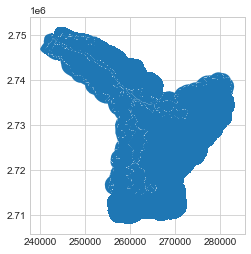

In [10]:
# calculate subbasins with a minimum stream order 7
subbas = flw.subbasins_streamorder(min_sto=7, mask=None)
gdf_subbas = vectorize(subbas.astype(np.int32), 0, flw.transform)

#plot
if my:
    gdf_subbas.plot()
    gdf_subbas.to_file('output/river_c1300_subbas.geojson', driver='GeoJSON')
    
else:
    cmap = colors.ListedColormap(cm.Set3(np.random.rand(68))) # create a nice random colormap
    bas1 = (gdf_subbas, dict(edgecolor='black', facecolor='none', linewidth=0.8))
    subbas1 = (subbas, 0, dict(cmap=cmap, alpha=0.5))
    title='Subbasins based on a minimum stream order'
    ax = quickplot([streams, bas1], [subbas1], title=title, filename='flw_subbasins')

In [5]:
# 有 Error , 目前不會解決
# get the first level nine pfafstetter basins
pfafbas1 = flw.subbasins_pfafstetter(depth=1, uparea=uparea)
gdf_pfaf1 = vectorize(pfafbas1.astype(np.int32), 0, flw.transform)

# plot
if my:
    gdf_pfaf1.plot()
    
else:
    pfafbas = (pfafbas1, 0, dict(cmap='Set3', alpha=0.5))
    pfaf1 = (gdf_pfaf1, dict(edgecolor='black', facecolor='none', linewidth=0.8))
    title='Subbasins based on pfafstetter coding (level=1)'
    #ax = quickplot([streams, pfaf1], [pfafbas], title=title, filename='flw_pfafbas1')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function atleast_1d at 0x7fa9018ce950>) found for signature:
 
 >>> atleast_1d(float64)
 
There are 2 candidate implementations:
   - Of which 2 did not match due to:
   Overload of function 'atleast_1d': File: numba/core/typing/npydecl.py: Line 724.
     With argument(s): '(float64)':
    No match.

During: resolving callee type: Function(<function atleast_1d at 0x7fa9018ce950>)
During: typing of call at /Volumes/F2020/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pyflwdir/basins.py (166)


File "../../../../Volumes/F2020/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pyflwdir/basins.py", line 166:
def subbasins_pfafstetter(idxs_pit, idxs_ds, seq, uparea, upa_min=0, depth=1, mv=_mv):
    <source elided>
    #
    upa_min = np.atleast_1d(upa_min)
    ^


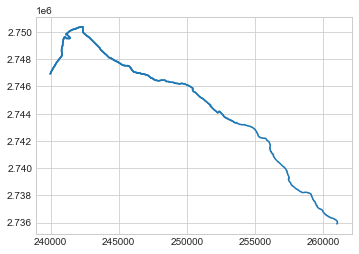

In [39]:
# 算通過點的下游路線
# flow paths return the list of linear indices
if my:
    xy=[[260993,2735861,'油羅上坪匯流'],[253520,2743364,'隆恩堰'],[247785,2746443,'湳雅取水口']]
    xy=([260993, 253520, 247785], [2735861, 2743364, 2746443])
    
else:
    xy=([8.92, 5.55, 8.50], [50.28, 49.80, 47.3])
flowpaths, dists = flw.path(xy=xy, max_length=400e3, unit='m')
# which we than use to vectorize to geofeatures
feats = flw.geofeatures(flowpaths)
gdf_paths = gpd.GeoDataFrame.from_features(feats, crs=crs).reset_index()
gdf_pnts = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*xy)).reset_index()
# and plot
my=1
if my:
    gdf_paths.plot()
    gdf_paths.to_file('output/river_c1300_path.geojson', driver='GeoJSON')
    #gdf_pnts.plot()
else:
    pnt = (gdf_pnts, dict(column='index', cmap='tab10', s=60, marker='<', zorder=4))
    fp = (gdf_paths, dict(column='index', cmap='tab10', linewidth=2))
    title='Flow path from source points (<) with max. distance of 400 km)'
    ax = quickplot([streams, fp, pnt], title=title, filename='flw_path2')

# 有用的

In [196]:
# 河道不同細緻度
for i in range(4,12):
    feats = flw.streams(min_sto=i)
    print("min_sto=%i count %i" %(i,len(feats)))
    gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
    gdf.to_file('output/river_c1300_%i.geojson' %(i), driver='GeoJSON')


min_sto=4 count 38969
min_sto=5 count 8783
min_sto=6 count 2034
min_sto=7 count 477
min_sto=8 count 106
min_sto=9 count 23
min_sto=10 count 5
min_sto=11 count 1


In [236]:
# 通過點的上游流域
points=[[260993,2735861,'油羅上坪匯流'],[253520,2743364,'隆恩堰'],[247785,2746443,'湳雅取水口']]
bas=[]
for p in points:
    x, y = np.array([p[0], p[0]+250]), np.array([p[1], p[1]+250])
    subbasins = flw.basins(xy=(x,y), streams=flw.stream_order()>=4)
    gdf_bas = vectorize(subbasins.astype(np.int32), 0, flw.transform)
    
    gdf_bas.to_file('output/river_c1300_basin_%s.geojson' %(p[2]), driver='GeoJSON')
    bas.append(gdf_bas)


In [283]:
#求  隆恩堰 - 油羅上坪匯流 的集水區差
a=bas[1].iloc[1]['geometry'] # iloc[0],iloc[1] 不是一樣的，要用 iloc[1] 才對
b=bas[0].iloc[1]['geometry']

c=a.difference(b)

gs = gpd.GeoSeries([c])
if 0: # 兩種方式輸出，效果相同
    gs.to_file('output/basin_diff_2point.geojson', driver='GeoJSON')
if 1:
    geojson = gs.to_json()
    with open("output/basin_diff_2point.geojson", "w") as out:
        out.write(geojson)

In [84]:
# 觀察 stream 的連接性
coords={}
for index, row in gdf.iterrows():
    line = row['geometry']
    idxs=row['idxs']
    points = list(line.coords)
    start = points[0]
    end = points[len(points)-1]
    coords[index]=[start,end]
    print("index=%i,length=%i,seg cnt=%i,start=%s,end=%s,idxs=%i" %(index,line.length,len(line.coords),start,end,idxs))

link={}
for key in coords.keys():
    start,end = coords[key]
    for key2 in coords.keys():
        start2,end2 = coords[key2]
        if end==start2:
            if key in link:
                print("index=%i already have start=%i" %(key,link[key]))
            link[key]=key2
print("link=%s" %(link))

if 0:
    for i in range(len(gdf.index)):
        if i in link.keys():
            #print("index=%i PASS" %(i))
            pass
        else:
            print("index=%i,info=%s" %(index,gdf.iloc[i]))

for l in link:
    print("N%i->N%i" %(l,link[l]))
#print(gdf.iloc[22]['geometry'])

index=0,length=64969,seg cnt=2757,start=(255899.35821683484, 2715201.503052526),end=(243037.8826793119, 2749385.4248069185),idxs=3998929
index=1,length=14610,seg cnt=637,start=(265760.48953876144, 2715881.5810745563),end=(261640.01681600916, 2721442.21901939),idxs=3925302
index=2,length=4380,seg cnt=191,start=(264300.32202050457, 2721542.230493218),end=(261640.01681600916, 2721442.21901939),idxs=3308289
index=3,length=22579,seg cnt=977,start=(261640.01681600916, 2721442.21901939),end=(260999.9433833486, 2735863.87354538),idxs=3319056
index=4,length=3733,seg cnt=157,start=(275261.5795548165, 2730263.231011015),end=(272241.23304444953, 2731443.3664021846),idxs=2358357
index=5,length=6186,seg cnt=261,start=(274941.5428384862, 2736243.917145926),end=(270661.0517575688, 2733223.5706363223),idxs=1706521
index=6,length=2476,seg cnt=107,start=(271181.11142160546, 2729603.1552837505),end=(272241.23304444953, 2731443.3664021846),idxs=2430093
index=7,length=3054,seg cnt=133,start=(272241.23304444

In [137]:
#測試用一個接近點，切開一個線段
from shapely.ops import split
from shapely.geometry import *
from shapely.ops import snap
from shapely.ops import nearest_points
if 0: #split
    pt = Point((1.15, 1.1))
    line = LineString([(0,0), (2,2)])
    result = split(line, pt)
    #result.wkt 
if 0: # snap
    square = Polygon([(1,1), (2, 1), (2, 2), (1, 2), (1, 1)])
    line = LineString([(0,0), (0.8, 0.8), (1.8, 0.95), (2.6, 0.5)])
    result = snap(line, square, 0.5)
    print(result.wkt)
if 0: # 點切開線
    pt = Point((1.1, 1))
    line = LineString([(0,0), (2,2)])
    print(line)
    #print("line within point:%s,dist=%f"% (line.within(pt),line.distance(pt)))
    nearp=nearest_points(line, pt)
    pt_in = nearp[0]
    #print(pt_in)
    result = split(line, pt_in)    
    print(result.wkt)
if 1:# 圳路接入主流
    line = LineString([(0,0), (2,2)])
    line_add=LineString([(1.1,1), (1.5,0.5)])
    pt = Point(list(line_add.coords)[0])
    if 1:
        pt_in = nearest_points(line, pt)[0]
        print(pt_in)

        pts = []
        pts.append(list(pt_in.coords)[0])
        pts.extend(list(line_add.coords))
        line_add_new = LineString(pts)
        print(line_add_new)

        result = split(line, pt_in)  
        print(result.wkt)
    
type(result)
    

POINT (1.05 1.05)
LINESTRING (1.05 1.05, 1.1 1, 1.5 0.5)
GEOMETRYCOLLECTION (LINESTRING (0 0, 1.05 1.05), LINESTRING (1.05 1.05, 2 2))


shapely.geometry.collection.GeometryCollection

In [174]:
#圳路接入主流
# line_ori:要修改的線, line_need:想加入的線, line_append:更新起點的想加入線, line_split:要修改的線被匯流點切開的結果
#取得圳路 linestring
from shapely import wkt
wkt_str="MultiLineString ((255779.34444821099168621 2742184.59869130607694387, 255062.52472444207523949 2741882.12604631343856454, 254328.86074706495855935 2742279.99766481388360262))"
line_need = wkt.loads(wkt_str)
print("line_need=%s" %(line_need))
#經由圳路的起點，找到最接近需要修改的線
start = Point(list(line_need.geoms[0].coords)[0])
print("start:%s" %(start))
dist_min=5000
idx_min=None
for index, row in gdf.iterrows():
    line = row['geometry']
    dist = line.distance(start)
    if dist<dist_min:
        dist_min=dist
        idx_min=index
print("index=%i, minimal distance=%f" %(idx_min,dist_min))
#找到匯流點
line_ori = gdf.loc[idx_min]['geometry']
pt_in = nearest_points(line_ori, start)[0]
#修改圳路起點為匯流點
pts = []
pts.append(list(pt_in.coords)[0])
for i in range(len(line_need.geoms)):
    pts.extend(list(line_need.geoms[i].coords))
line_append = LineString(pts)
print("line_append=%s" %(line_append))
#取得主流切開後的兩線段
line_split = split(line_ori, pt_in) 
print("line_split=%s"%(line_split))
#在 gdf 中刪掉原線段，加入兩新線段,加入修改後的圳路
idx_start = len(gdf.index)

gdf.loc[idx_start]=[line_append,100,False,9] #geometry,idxs,pit,strord
for i in range(len(line_split)):
    gdf.loc[idx_start+i+1]=[line_split[i],100+i+1,False,9]
gdf.drop(idx_min,axis=0,inplace=True)
gdf.to_file('output/river_c1300_mergeline.geojson', driver='GeoJSON')

line_need=MULTILINESTRING ((255779.344448211 2742184.598691306, 255062.5247244421 2741882.126046313, 254328.860747065 2742279.997664814))
start:POINT (255779.344448211 2742184.598691306)
index=11, minimal distance=0.000000
line_append=LINESTRING (255779.344448211 2742184.598691306, 255779.344448211 2742184.598691306, 255062.5247244421 2741882.126046313, 254328.860747065 2742279.997664814)
line_split=GEOMETRYCOLLECTION (LINESTRING (259119.7276749082 2738084.128264361, 259099.7253801376 2738104.130559126, 259079.7230853669 2738124.132853892, 259059.7207905963 2738124.132853892, 259039.7184958257 2738144.135148657, 259019.716201055 2738144.135148657, 258999.7139062844 2738164.137443423, 258979.7116115137 2738164.137443423, 258959.7093167431 2738164.137443423, 258939.7070219725 2738184.139738188, 258919.7047272018 2738184.139738188, 258899.7024324312 2738184.139738188, 258879.7001376605 2738184.139738188, 258859.6978428899 2738204.142032954, 258839.6955481193 2738204.142032954, 258819.6932


# Debug

In [151]:
#geopandas drop/insert rows test
if 0:
    line = LineString([(0,0), (0.8, 0.8), (1.8, 0.95), (2.6, 0.5)])
    #gdf.loc[23]=[line,1234,False,3]
    #gdf.columns
    gdf.drop(23,axis=0,inplace=True)
gdf

,geometry,idxs,pit,strord
0,"LINESTRING (255899.358 2715201.503, 255879.356...",3998929,False,9
1,"LINESTRING (265760.490 2715881.581, 265740.487...",3925302,False,9
2,"LINESTRING (264300.322 2721542.230, 264280.320...",3308289,False,9
3,"LINESTRING (261640.017 2721442.219, 261620.015...",3319056,False,10
4,"LINESTRING (275261.580 2730263.231, 275241.577...",2358357,False,9
5,"LINESTRING (274941.543 2736243.917, 274921.541...",1706521,False,9
6,"LINESTRING (271181.111 2729603.155, 271201.114...",2430093,False,9
7,"LINESTRING (272241.233 2731443.366, 272241.233...",2229586,False,10
8,"LINESTRING (270661.052 2733223.571, 270641.049...",2035487,False,10
9,"LINESTRING (266080.526 2735703.855, 266060.524...",1764938,False,9


In [169]:
type(line_split[0])

shapely.geometry.linestring.LineString

In [79]:
#len(gdf.index)
link
#gdf
#transform
#c=gdf.iloc[19]['geometry']
#print(c)
#c
#df_c = gpd.GeoSeries([c])
#df_c.plot()
#crs.to_epsg()
#flwdir
#elevtn
#np.savetxt('output/debug.csv', flwdir, delimiter=',')
#src2.crs

#flwdir[flwdir==-1].dtype
#flwdir[flwdir==-32767]
#flwdir
#flwdir[flwdir==-9999]
#np.savetxt('output/debug.csv', uparea[uparea!=-9999], delimiter=',')

    #pt_in = snap(pt, line, 1)
    #line_in = snap(line,pt, 0.5)

{0: 17,
 1: 3,
 2: 3,
 3: 10,
 4: 7,
 5: 8,
 6: 7,
 7: 8,
 8: 10,
 9: 11,
 10: 11,
 11: 16,
 12: 15,
 13: 15,
 14: 16,
 15: 18,
 16: 17,
 17: 18,
 21: 21,
 22: 22}

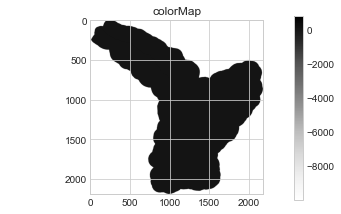

In [130]:
import numpy as np
import matplotlib.pyplot as plt

H = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])  # added some commas and array creation code

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(uparea)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [83]:
from shapely import wkt
wkt_str="MultiLineString ((255779.34444821099168621 2742184.59869130607694387, 255062.52472444207523949 2741882.12604631343856454, 254328.86074706495855935 2742279.99766481388360262))"
p1 = wkt.loads(wkt_str)
gs = gpd.GeoSeries([p1])
gs

0    MULTILINESTRING ((255779.344 2742184.599, 2550...
dtype: geometry

# geopandas 練習

In [13]:
import geopandas

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [14]:
gdf.area

0    1.623822e+09
1    3.045214e+09
2    1.937478e+09
3    6.364712e+08
4    1.186926e+09
dtype: float64

In [ ]:
sql="select * from basin"
geopandas.read_postgis(sql,connn)

geopandas.read_postgis(sql, con, geom_col='geom', crs=None, index_col=None, coerce_float=True, parse_dates=None, params=None, chunksize=None)